In [9]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

In [10]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0



In [11]:
def regroup_together(affinities, weights , original_indices):
    affinities = affinities.ravel()
    weights = weights.ravel()
    assert affinities.shape == weights.shape, "%s should be %s" % (affinities.shape, weights.shape)
    assert affinities.shape == original_indices.shape
    assert len(affinities) == len(affinities.ravel())
    weighted_affinities = (affinities * weights)
    index_set = set(original_indices)
    n_indices = len(index_set)
    result_order = {original_index: i for (i, original_index) in enumerate(sorted(index_set))}
    result = np.zeros(n_indices)
    for i, x in enumerate(weighted_affinities):
        result_idx = result_order[original_indices[i]]
        result[result_idx] += x
    return result
def slicing(dataset,index, i):
    return dataset.slice(index).kmer_index_encoding()[i]
def label_transform(array):
    result = 1-np.log(array)/math.log(50000)
    result[result<0]=0
    return result
def index_to_hotshot_encoding(index_encoded_peptide):
    result = np.zeros((len(index_encoded_peptide),21))
    for position, amino_acid in enumerate(index_encoded_peptide):
        result[position][amino_acid]= 1
    return result.flatten()
def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)


def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])


def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

In [12]:
def first_and_last_three(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:3],Y[-3+k:k]])
def first_and_last_four(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:4],Y[-4+k:k]])
def first_and_last_two(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:2],Y[-2+k:k]])
X_44 = np.apply_along_axis(first_and_last_four,1,X)
X_33 = np.apply_along_axis(first_and_last_three,1,X)
X_22 = np.apply_along_axis(first_and_last_two,1,X)

In [13]:
ds = Dataset.from_csv("bdata.2009.mhci.public.1.txt")
ds_h = ds.slice(ds.alleles == 'HLA-A0201')

In [14]:
folds =3 
n_epochs = 50

train_sigmoid_aucs = np.zeros((folds,n_epochs))
test_sigmoid_aucs = np.zeros((folds,n_epochs))
nine_train_sigmoid_aucs = np.zeros((folds,n_epochs))
nine_test_sigmoid_aucs = np.zeros((folds,n_epochs))
non_nine_train_sigmoid_aucs = np.zeros((folds,n_epochs))
non_nine_test_sigmoid_aucs = np.zeros((folds,n_epochs))

train_sigmoid_22_aucs = np.zeros((folds,n_epochs))
test_sigmoid_22_aucs = np.zeros((folds,n_epochs))
nine_train_sigmoid_22_aucs = np.zeros((folds,n_epochs))
nine_test_sigmoid_22_aucs = np.zeros((folds,n_epochs))
non_nine_train_sigmoid_22_aucs = np.zeros((folds,n_epochs))
non_nine_test_sigmoid_22_aucs = np.zeros((folds,n_epochs))

train_sigmoid_33_aucs = np.zeros((folds,n_epochs))
test_sigmoid_33_aucs = np.zeros((folds,n_epochs))
nine_train_sigmoid_33_aucs = np.zeros((folds,n_epochs))
nine_test_sigmoid_33_aucs = np.zeros((folds,n_epochs))
non_nine_train_sigmoid_33_aucs = np.zeros((folds,n_epochs))
non_nine_test_sigmoid_33_aucs = np.zeros((folds,n_epochs))

train_sigmoid_44_aucs = np.zeros((folds,n_epochs))
test_sigmoid_44_aucs = np.zeros((folds,n_epochs))
nine_train_sigmoid_44_aucs = np.zeros((folds,n_epochs))
nine_test_sigmoid_44_aucs = np.zeros((folds,n_epochs))
non_nine_train_sigmoid_44_aucs = np.zeros((folds,n_epochs))
non_nine_test_sigmoid_44_aucs = np.zeros((folds,n_epochs))

train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))
nine_train_lstm_aucs = np.zeros((folds,n_epochs))
nine_test_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_train_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_test_lstm_aucs = np.zeros((folds,n_epochs))

In [15]:
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    
    # Linear Regression 
    lr = LinearRegression()
    
    # sigmoid
    sigmoid = Sequential()
    sigmoid.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    sigmoid.add(Flatten())
    sigmoid.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    sigmoid.compile(optimizer = 'adam', loss='mean_squared_error')
    
    sigmoid_22 = Sequential()
    sigmoid_22.add(Embedding(input_dim = 21, input_length =4, output_dim= 32))
    sigmoid_22.add(Flatten())
    sigmoid_22.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    sigmoid_22.compile(optimizer = 'adam', loss='mean_squared_error')
    
    sigmoid_33 = Sequential()
    sigmoid_33.add(Embedding(input_dim = 21, input_length =6, output_dim= 32))
    sigmoid_33.add(Flatten())
    sigmoid_33.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    sigmoid_33.compile(optimizer = 'adam', loss='mean_squared_error')
    
    sigmoid_44 = Sequential()
    sigmoid_44.add(Embedding(input_dim = 21, input_length =8, output_dim= 32))
    sigmoid_44.add(Flatten())
    sigmoid_44.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    sigmoid_44.compile(optimizer = 'adam', loss='mean_squared_error')
    
    # normal LSTM
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    adam = Adam(lr = 0.01)
    lstm.compile(optimizer = adam , loss='mean_squared_error')
    
    # index sets
    
    nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])==9)])
    non_nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])!=9)])
    nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])==9)])
    non_nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])!=9)])
    
    # training sets
    
    
    X_train = slicing(ds_h,train_idx,0)
    y_train = label_transform(slicing(ds_h,train_idx,1))
    
    X_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_train )
    
    X_nine_train = slicing(ds_h,nine_train_idx,0)
    y_nine_train = label_transform(slicing(ds_h,nine_train_idx,1))
    
    X_nine_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_nine_train )
    
    X_non_nine_train = slicing(ds_h,non_nine_train_idx,0)
    y_non_nine_train = label_transform(slicing(ds_h,non_nine_train_idx,1))
    
    X_non_nine_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_non_nine_train )
    
    
    # test sets
    
    X_test = slicing(ds_h,test_idx,0)
    y_test = label_transform(slicing(ds_h,test_idx,1))
    
    X_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_test)
    
    X_nine_test = slicing(ds_h,nine_test_idx,0)
    y_nine_test = label_transform(slicing(ds_h,nine_test_idx,1))
    
    X_nine_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_nine_test)
    
    X_non_nine_test = slicing(ds_h,non_nine_test_idx,0)
    y_non_nine_test = label_transform(slicing(ds_h,non_nine_test_idx,1))
    
    X_non_nine_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_non_nine_test)
    
    # weights
    
    weights_train = slicing(ds_h,train_idx,2)
    weights_test = slicing(ds_h,test_idx,2)
    
    weights_nine_train = slicing(ds_h,nine_train_idx,2)
    weights_nine_test = slicing(ds_h,nine_test_idx,2)
    
    weights_non_nine_train = slicing(ds_h,non_nine_train_idx,2)
    weights_non_nine_test = slicing(ds_h,non_nine_test_idx,2)
    
    # original indices
    
    original_indices_train = slicing(ds_h,train_idx,3)
    original_indices_test = slicing(ds_h,test_idx,3)
    
    original_indices_nine_train = slicing(ds_h,nine_train_idx,3)
    original_indices_nine_test = slicing(ds_h,nine_test_idx,3)
    
    original_indices_non_nine_train = slicing(ds_h,non_nine_train_idx,3)
    original_indices_non_nine_test = slicing(ds_h,non_nine_test_idx,3)
    
    # real labels (to be used for AUC score calculation)
    
    train_real_labels = regroup_together(y_train, weights_train , original_indices_train)
    test_real_labels = regroup_together(y_test, weights_test , original_indices_test)
    
    nine_train_real_labels = regroup_together(y_nine_train, weights_nine_train , original_indices_nine_train)
    nine_test_real_labels = regroup_together(y_nine_test, weights_nine_test , original_indices_nine_test)
    
    non_nine_train_real_labels = regroup_together(y_non_nine_train, weights_non_nine_train , original_indices_non_nine_train)
    non_nine_test_real_labels = regroup_together(y_non_nine_test, weights_non_nine_test , original_indices_non_nine_test)
    
    for epoch in range(n_epochs):
        
        sigmoid.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_nn, nb_epoch=1)
        
        train_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_train), weights_train, original_indices_train)
        test_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)

        
        
        train_sigmoid_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_grouped_sigmoid)     
        test_sigmoid_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_grouped_sigmoid)
        nine_train_sigmoid_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500), nine_train_pred_grouped_sigmoid)     
        nine_test_sigmoid_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500), nine_test_pred_grouped_sigmoid)
        non_nine_train_sigmoid_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500), non_nine_train_pred_grouped_sigmoid)     
        non_nine_test_sigmoid_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500), non_nine_test_pred_grouped_sigmoid)
        
        
        train_sigmoid_aucs[i][epoch]=train_sigmoid_auc
        test_sigmoid_aucs[i][epoch]=test_sigmoid_auc
        nine_train_sigmoid_aucs[i][epoch]=nine_train_sigmoid_auc
        nine_test_sigmoid_aucs[i][epoch]=nine_test_sigmoid_auc
        non_nine_train_sigmoid_aucs[i][epoch]=non_nine_train_sigmoid_auc
        non_nine_test_sigmoid_aucs[i][epoch]=non_nine_test_sigmoid_auc
        
        sigmoid_22.fit(X_22[train_idx],y[train_idx], batch_size = batch_size_nn, nb_epoch=1)
        sigmoid_33.fit(X_33[train_idx],y[train_idx], batch_size = batch_size_nn, nb_epoch=1)
        sigmoid_44.fit(X_44[train_idx],y[train_idx], batch_size = batch_size_nn, nb_epoch=1)
        
        train_sigmoid_22_aucs[i][epoch] = roc_auc_score(measured_affinity_less_than(y[train_idx],500), sigmoid_22.predict(X_22[train_idx]))     
        test_sigmoid_22_aucs[i][epoch] = roc_auc_score(measured_affinity_less_than(y[test_idx],500), sigmoid_22.predict(X_22[test_idx]))
        nine_train_sigmoid_22_aucs[i][epoch] = roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500), sigmoid_22.predict(X_22[nine_train_idx]))     
        nine_test_sigmoid_22_aucs[i][epoch] = roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500), sigmoid_22.predict(X_22[nine_test_idx]))
        non_nine_train_sigmoid_22_aucs[i][epoch] = roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500), sigmoid_22.predict(X_22[non_nine_train_idx]))     
        non_nine_test_sigmoid_22_aucs[i][epoch] = roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500), sigmoid_22.predict(X_22[non_nine_test_idx]))
    
        train_sigmoid_33_aucs[i][epoch]=  roc_auc_score(measured_affinity_less_than(y[train_idx],500), sigmoid_33.predict(X_33[train_idx]))     
        test_sigmoid_33_aucs[i][epoch] = roc_auc_score(measured_affinity_less_than(y[test_idx],500), sigmoid_33.predict(X_33[test_idx]))
        nine_train_sigmoid_33_aucs[i][epoch]=  roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500), sigmoid_33.predict(X_33[nine_train_idx]))     
        nine_test_sigmoid_33_aucs[i][epoch] = roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500), sigmoid_33.predict(X_33[nine_test_idx]))
        non_nine_train_sigmoid_33_aucs[i][epoch]=  roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500), sigmoid_33.predict(X_33[non_nine_train_idx]))     
        non_nine_test_sigmoid_33_aucs[i][epoch]= roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500), sigmoid_33.predict(X_33[non_nine_test_idx]))
    
        train_sigmoid_44_aucs[i][epoch]= roc_auc_score(measured_affinity_less_than(y[train_idx],500), sigmoid_44.predict(X_44[train_idx]))     
        test_sigmoid_44_aucs[i][epoch]= roc_auc_score(measured_affinity_less_than(y[test_idx],500), sigmoid_44.predict(X_44[test_idx]))
        nine_train_sigmoid_44_aucs[i][epoch]= roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500), sigmoid_44.predict(X_44[nine_train_idx]))     
        nine_test_sigmoid_44_aucs[i][epoch]= roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500), sigmoid_44.predict(X_44[nine_test_idx]))
        non_nine_train_sigmoid_44_aucs[i][epoch]= roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500), sigmoid_44.predict(X_44[non_nine_train_idx]))     
        non_nine_test_sigmoid_44_aucs[i][epoch]= roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500), sigmoid_44.predict(X_44[non_nine_test_idx]))
    
        adam.lr.set_value(0.01*(epoch+1)**(-2))
        lstm.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm.predict(X[train_idx]))
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm.predict(X[test_idx]))
        nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500),lstm.predict(X[nine_train_idx]))
        nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500),lstm.predict(X[nine_test_idx]))
        non_nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500),lstm.predict(X[non_nine_train_idx]))
        non_nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500),lstm.predict(X[non_nine_test_idx]))
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        nine_train_lstm_aucs[i][epoch]=nine_train_lstm_auc
        nine_test_lstm_aucs[i][epoch]=nine_test_lstm_auc
        non_nine_train_lstm_aucs[i][epoch]=non_nine_train_lstm_auc
        non_nine_test_lstm_aucs[i][epoch]=non_nine_test_lstm_auc


Epoch 1/1
21785/21785 [==============================] - 0s - loss: 0.0140     
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0686     
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0649     
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0636     
Epoch 1/1
6376/6376 [==============================] - 9s - loss: 0.0435     
Epoch 1/1
21785/21785 [==============================] - 0s - loss: 0.0089     
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0433     
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0347     
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0324     
Epoch 1/1
6376/6376 [==============================] - 8s - loss: 0.0269     
Epoch 1/1
21785/21785 [==============================] - 0s - loss: 0.0085     
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0405     
Epoch 1/1
6376/6376 [==============================] - 0s 

In [16]:
train_sigmoid_aucs_mean = np.mean(train_sigmoid_aucs, axis=0)
test_sigmoid_aucs_mean = np.mean(test_sigmoid_aucs, axis=0)

train_sigmoid_22_aucs_mean = np.mean(train_sigmoid_22_aucs, axis=0)
test_sigmoid_22_aucs_mean = np.mean(test_sigmoid_22_aucs, axis=0)

train_sigmoid_33_aucs_mean = np.mean(train_sigmoid_33_aucs, axis=0)
test_sigmoid_33_aucs_mean = np.mean(test_sigmoid_33_aucs, axis=0)

train_sigmoid_44_aucs_mean = np.mean(train_sigmoid_44_aucs, axis=0)
test_sigmoid_44_aucs_mean = np.mean(test_sigmoid_44_aucs, axis=0)

train_lstm_aucs_mean = np.mean(train_lstm_aucs, axis=0)
test_lstm_aucs_mean = np.mean(test_lstm_aucs, axis=0)

In [17]:
nine_train_sigmoid_aucs_mean = np.mean(nine_train_sigmoid_aucs, axis=0)
nine_test_sigmoid_aucs_mean = np.mean(nine_test_sigmoid_aucs, axis=0)

nine_train_sigmoid_22_aucs_mean = np.mean(nine_train_sigmoid_22_aucs, axis=0)
nine_test_sigmoid_22_aucs_mean = np.mean(nine_test_sigmoid_22_aucs, axis=0)

nine_train_sigmoid_33_aucs_mean = np.mean(nine_train_sigmoid_33_aucs, axis=0)
nine_test_sigmoid_33_aucs_mean = np.mean(nine_test_sigmoid_33_aucs, axis=0)

nine_train_sigmoid_44_aucs_mean = np.mean(nine_train_sigmoid_44_aucs, axis=0)
nine_test_sigmoid_44_aucs_mean = np.mean(nine_test_sigmoid_44_aucs, axis=0)

nine_train_lstm_aucs_mean = np.mean(nine_train_lstm_aucs, axis=0)
nine_test_lstm_aucs_mean = np.mean(nine_test_lstm_aucs, axis=0)

In [18]:
non_nine_train_sigmoid_aucs_mean = np.mean(non_nine_train_sigmoid_aucs, axis=0)
non_nine_test_sigmoid_aucs_mean = np.mean(non_nine_test_sigmoid_aucs, axis=0)

non_nine_train_sigmoid_22_aucs_mean = np.mean(non_nine_train_sigmoid_22_aucs, axis=0)
non_nine_test_sigmoid_22_aucs_mean = np.mean(non_nine_test_sigmoid_22_aucs, axis=0)

non_nine_train_sigmoid_33_aucs_mean = np.mean(non_nine_train_sigmoid_33_aucs, axis=0)
non_nine_test_sigmoid_33_aucs_mean = np.mean(non_nine_test_sigmoid_33_aucs, axis=0)

non_nine_train_sigmoid_44_aucs_mean = np.mean(non_nine_train_sigmoid_44_aucs, axis=0)
non_nine_test_sigmoid_44_aucs_mean = np.mean(non_nine_test_sigmoid_44_aucs, axis=0)

non_nine_train_lstm_aucs_mean = np.mean(non_nine_train_lstm_aucs, axis=0)
non_nine_test_lstm_aucs_mean = np.mean(non_nine_test_lstm_aucs, axis=0)

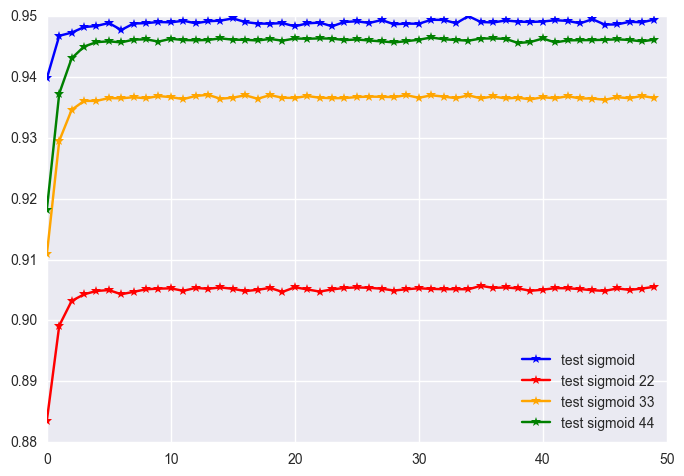

In [9]:
plt.plot( np.arange(0,50,1), test_sigmoid_aucs_mean[0:50],color='b',marker='*', linestyle='-', label ="test sigmoid")
plt.plot( np.arange(0,50,1), test_sigmoid_22_aucs_mean[0:50],color='r',marker='*', linestyle='-', label ="test sigmoid 22")
plt.plot( np.arange(0,50,1), test_sigmoid_33_aucs_mean[0:50],color='orange',marker='*', linestyle='-', label ="test sigmoid 33")
plt.plot( np.arange(0,50,1), test_sigmoid_44_aucs_mean[0:50],color='g',marker='*', linestyle='-', label ="test sigmoid 44")
plt.plot( np.arange(0,50,1), test_lstm_aucs_mean[0:50],color='c',marker='*', linestyle='-', label ="test LSTM")

plt.legend(loc=4)

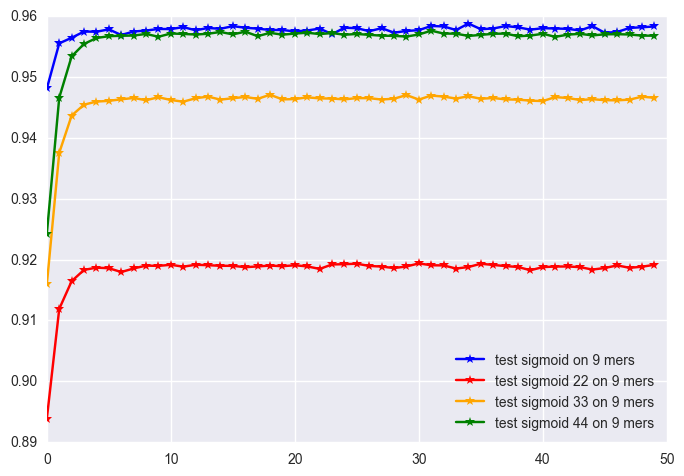

In [12]:
plt.plot( np.arange(0,50,1), nine_test_sigmoid_aucs_mean[0:50],color='b',marker='*', linestyle='-', label ="test sigmoid on 9 mers")
plt.plot( np.arange(0,50,1), nine_test_sigmoid_22_aucs_mean[0:50],color='r',marker='*', linestyle='-', label ="test sigmoid 22 on 9 mers")
plt.plot( np.arange(0,50,1), nine_test_sigmoid_33_aucs_mean[0:50],color='orange',marker='*', linestyle='-', label ="test sigmoid 33 on 9 mers")
plt.plot( np.arange(0,50,1), nine_test_sigmoid_44_aucs_mean[0:50],color='g',marker='*', linestyle='-', label ="test sigmoid 44 on 9 mers")
plt.plot( np.arange(0,50,1), nine_test_lstm_aucs_mean[0:50],color='c',marker='*', linestyle='-', label ="test LSTM on 9 mers")


plt.legend(loc=4)

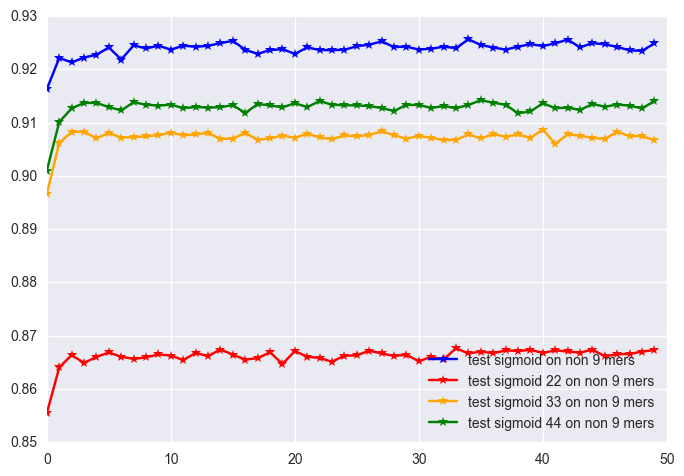

In [15]:
plt.plot( np.arange(0,50,1), non_nine_test_sigmoid_aucs_mean[0:50],color='b',marker='*', linestyle='-', label ="test sigmoid on non 9 mers")
plt.plot( np.arange(0,50,1), non_nine_test_sigmoid_22_aucs_mean[0:50],color='r',marker='*', linestyle='-', label ="test sigmoid 22 on non 9 mers")
plt.plot( np.arange(0,50,1), non_nine_test_sigmoid_33_aucs_mean[0:50],color='orange',marker='*', linestyle='-', label ="test sigmoid 33 on non 9 mers")
plt.plot( np.arange(0,50,1), non_nine_test_sigmoid_44_aucs_mean[0:50],color='g',marker='*', linestyle='-', label ="test sigmoid 44 on non 9 mers")
plt.plot( np.arange(0,50,1), non_nine_test_lstm_aucs_mean[0:50],color='c',marker='*', linestyle='-', label ="test LSTM on non 9 mers")


plt.legend(loc=4)